In [1]:
import torch
import torch.nn as nn
# import os
import numpy as np
# import math
import os
from torch.autograd import Variable
# from torch.utils.data import Dataset
# import torch.optim as optim 
# import random

# from sklearn.metrics import r2_score, explained_variance_score

# from networks.Network1_v1 import Network1, Network1_Data_loader
# from networks.Network1_v5 import Network1, Network1_Data_loader
# from networks.Network1_v2 import Network1, Network1_Data_loader
# from networks.Network1_v3 import Network1, Network1_Data_loader
from networks.Network1_v31 import Network1, Network1_Data_loader
# from networks.Network1_v32 import Network1, Network1_Data_loader
# from networks.Network1_v33 import Network1, Network1_Data_loader
# from networks.Network1_v34 import Network1, Network1_Data_loader
# from networks.Network3 import Network3, Network3_Data_loader

from matplotlib import pyplot as plt

### Data Preprocessing

In [2]:
def data_extractor(filename, processed_filename1, processed_filename2=None):
    # cleans IMU outputs and generates usable dataset as a clean CSV file
    
    file = open(filename, 'r')
    out_file1 = open(processed_filename1, 'w')
    if processed_filename2 is not None:
        out_file2 = open(processed_filename2, 'w')
    
    start_time, end_time, time  = '', '', ''
    lin_ctr = 0
    
    for l in file:
        if l[0] == '[':                              # if data has timestamp logging on
            time, line = l[10:22], l[24:].rstrip()
        else:
            line = l.rstrip()
            
        tab_ctr = line.count("\t")
        if tab_ctr == 3 or tab_ctr == 9:
            lin_ctr += 1
            line_lst = line.rstrip().split("\t")
            if line_lst[0]=='LSM_raw: ' :
                print(line.rstrip(), file=out_file2, end=";\t\t")
            elif line_lst[0]=='MPU_raw: ' :
                print(line.rstrip(), file=out_file1, end=";\t\t")
            elif line_lst[0]=='MPU_ypr: ' :
                print(line.rstrip(), file=out_file1, end="\n")
                print(line.rstrip(), file=out_file2, end="\n")
            if lin_ctr == 1 :
                start_time = time
            #elif line_lst[0]=='LSM_ypr: ' :
            #    print(line.rstrip(), file=out_file1, end="\n")
    
    end_time = time
    print("Start_time = {}; End_time = {}".format(start_time, end_time), file=out_file1, end="\n")
    
    if processed_filename2 is not None:
        print("Start_time = {}; End_time = {}".format(start_time, end_time), file=out_file2, end="\n")
        out_file2.close()
        
    out_file1.close()
    file.close()
    
def file_train_test_splitter(input_file_name, train_percent):
    # splits the input file into two files given by the train_percent
        # example usage : file_train_test_splitter("input.txt", 70)
    
    with open(input_file_name, 'r') as f:
        for i, l in enumerate(f):
            pass
    lines_in_file = i + 1   # total number of lines, aka, data points in the input file
    f.close()
    
    try:
        ratio = train_percent / 100
    except:
        print("Error: Invalid train test split ratio")
    
    num_train_data_points = int(lines_in_file * ratio)
    num_test_data_points = lines_in_file - num_train_data_points
    
    train_out_file = open(os.path.splitext(input_file_name)[0]+"_train_data.csv", 'w')
    test_out_file = open(os.path.splitext(input_file_name)[0]+"_test_data.csv", 'w')
    
    line_ctr = 0
    with open(input_file_name, 'r') as f:
        for line in f:
            line_ctr += 1
            line = line.rstrip()
            if line_ctr <= num_train_data_points:
                print(line, file = train_out_file)
            else:
                print(line, file = test_out_file)
    
    f.close()
    test_out_file.close()
    train_out_file.close()
    
    print("Train and test files created.")

In [3]:
# Data Pre-processing 

# data_extractor("Datasets/MPU_rawtoypr_11.csv", "Datasets/MPU_rawtoypr_11_cleaned.csv")
# file_train_test_splitter("Datasets/MPU_rawtoypr_11_cleaned.csv", 70)

trial_num = 4

data_extractor("Datasets/rawtoypr_{}.csv".format(trial_num), 
               "Datasets/MPU_rawtoypr_{}_cleaned.csv".format(trial_num), 
               "Datasets/LSM_rawto_MPUypr_{}_cleaned.csv".format(trial_num))

file_train_test_splitter("Datasets/LSM_rawto_MPUypr_{}_cleaned.csv".format(trial_num), 70)

Train and test files created.


### Deep Learning Network

In [16]:
# model = Network1(init_weights=True)
model = Network1(init_weights=True)
print(model)

Network1(
  (fc_y1): Linear(in_features=9, out_features=8)
  (fc_y2): Linear(in_features=8, out_features=7)
  (fc_y3): Linear(in_features=7, out_features=5)
  (fc_y4): Linear(in_features=5, out_features=3)
  (fc_y5): Linear(in_features=3, out_features=1)
  (fc_p1): Linear(in_features=9, out_features=8)
  (fc_p2): Linear(in_features=8, out_features=7)
  (fc_p3): Linear(in_features=7, out_features=5)
  (fc_p4): Linear(in_features=5, out_features=3)
  (fc_p5): Linear(in_features=3, out_features=1)
  (fc_r1): Linear(in_features=9, out_features=8)
  (fc_r2): Linear(in_features=8, out_features=7)
  (fc_r3): Linear(in_features=7, out_features=5)
  (fc_r4): Linear(in_features=5, out_features=3)
  (fc_r5): Linear(in_features=3, out_features=1)
  (relu): ReLU(inplace)
)


#### Initialize model weights from older checkpoint (if necessary)

In [17]:
# state_dict = model.load_from_checkpoint("/the_good_weights/net1_v5_network_state_checkpoint80.pth")
# state_dict = model.load_from_checkpoint("/the_good_weights/net1_v31_checkpoint95.pth")
# state_dict = model.load_from_checkpoint("/the_good_weights/net1_v31_lsm2mpu_checkpoint995.pth")
state_dict = model.load_from_checkpoint("/saved_model_weights/Net1_v3.1/network_state_checkpoint150.pth")

model.load_state_dict(state_dict)

Loading model from 
/Users/crohan009/Documents/Stuff/USR18/code base/Sensor_fusion/saved_model_weights/Net1_v3.1/network_state_checkpoint150.pth 
...onto the CPU. 



### Instantiating the Data Loader class

In [18]:
# training data LSM raw -> MPU ypr
data_train = Network1_Data_loader("Datasets/LSM_rawto_MPUypr_{}_cleaned_train_data.csv".format(trial_num), trans=True)    
data_test = Network1_Data_loader("Datasets/LSM_rawto_MPUypr_{}_cleaned_test_data.csv".format(trial_num), trans=True ) 

# data_train = Network1_Data_loader("Datasets/MPU_rawtoypr_11_cleaned_train_data.csv")     # training data LSM raw -> MPU ypr   
# data_test  = Network1_Data_loader("Datasets/MPU_rawtoypr_11_cleaned_train_data.csv") # testing data MPU raw -> MPU ypr

In [19]:
print("Total training data samples = ", len(data_train))
print("Training Data matrix shape = ",data_train.data_matrix.shape)

print("Total test data samples = ", len(data_test))
print("Test Data matrix shape = ",data_test.data_matrix.shape)

Total training data samples =  4545
Training Data matrix shape =  (4545, 12)
Total test data samples =  1947
Test Data matrix shape =  (1947, 12)


#### Some pre training / testing initializations . . .

In [37]:
# Initializing the DataLoader(s)
dsets_enqueuer_training = torch.utils.data.DataLoader(data_train, batch_size=1, 
                                                      num_workers=1, drop_last=False)
dsets_enqueuer_testing = torch.utils.data.DataLoader(data_test, batch_size=1, 
                                                      num_workers=1, drop_last=False)

epochs = 250

### Training / Testing the network

In [38]:
loss_lst_train, loss_lst_test, r_sq_lst, r_sq_lst_test,  var_exp_lst, var_exp_lst_test = model.train_model(epochs, 
                                                                                               dsets_enqueuer_training, 
                                                                                               dsets_enqueuer_testing)




[ Training Network ]

Epoch 	1 / 250 , 	 loss = [[1.8498829e-06 4.0925847e-06 1.7564027e-05]] , 	 R^2 = 0.9908 , 	 Var exp = 99.0839 %
Epoch 	2 / 250 , 	 loss = [[1.8285642e-06 4.2807678e-06 1.6671471e-05]] , 	 R^2 = 0.9906 , 	 Var exp = 99.0619 %
Epoch 	3 / 250 , 	 loss = [[1.8229065e-06 4.3533632e-06 1.6212831e-05]] , 	 R^2 = 0.9906 , 	 Var exp = 99.0624 %
Epoch 	4 / 250 , 	 loss = [[1.8219428e-06 4.4109856e-06 1.6034028e-05]] , 	 R^2 = 0.9905 , 	 Var exp = 99.0611 %
Epoch 	5 / 250 , 	 loss = [[1.8066416e-06 4.3340356e-06 1.5977819e-05]] , 	 R^2 = 0.9906 , 	 Var exp = 99.0655 %
Epoch 	6 / 250 , 	 loss = [[1.8128410e-06 4.2924953e-06 1.5937296e-05]] , 	 R^2 = 0.9906 , 	 Var exp = 99.0666 %
Epoch 	7 / 250 , 	 loss = [[1.8056945e-06 4.2742377e-06 1.5905813e-05]] , 	 R^2 = 0.9906 , 	 Var exp = 99.068 %
Epoch 	8 / 250 , 	 loss = [[1.7953461e-06 4.2553288e-06 1.5860454e-05]] , 	 R^2 = 0.9906 , 	 Var exp = 99.0696 %
Epoch 	9 / 250 , 	 loss = [[1.7913718e-06 4.2190568e-06 1.5829619e-05]] 

Epoch 	73 / 250 , 	 loss = [[1.3488808e-06 4.4635694e-06 1.3952829e-05]] , 	 R^2 = 0.9913 , 	 Var exp = 99.1338 %
Epoch 	74 / 250 , 	 loss = [[1.3534030e-06 4.4396834e-06 1.3944418e-05]] , 	 R^2 = 0.9913 , 	 Var exp = 99.1384 %
Epoch 	75 / 250 , 	 loss = [[1.3429936e-06 4.3919167e-06 1.3906103e-05]] , 	 R^2 = 0.9914 , 	 Var exp = 99.1437 %
Epoch 	76 / 250 , 	 loss = [[1.3448615e-06 4.3634373e-06 1.3874661e-05]] , 	 R^2 = 0.9914 , 	 Var exp = 99.1461 %
Epoch 	77 / 250 , 	 loss = [[1.3435438e-06 4.4050466e-06 1.3845528e-05]] , 	 R^2 = 0.9914 , 	 Var exp = 99.1473 %
Epoch 	78 / 250 , 	 loss = [[1.3380635e-06 4.3568743e-06 1.3820089e-05]] , 	 R^2 = 0.9914 , 	 Var exp = 99.1523 %
Epoch 	79 / 250 , 	 loss = [[1.3406489e-06 4.3976906e-06 1.3797793e-05]] , 	 R^2 = 0.9914 , 	 Var exp = 99.1529 %
Epoch 	80 / 250 , 	 loss = [[1.3359705e-06 4.4397534e-06 1.3786976e-05]] , 	 R^2 = 0.9915 , 	 Var exp = 99.1535 %
Epoch 	81 / 250 , 	 loss = [[1.3326962e-06 4.6662435e-06 1.3769478e-05]] , 	 R^2 = 0.991

Epoch 	145 / 250 , 	 loss = [[1.2069765e-06 3.0585225e-06 1.3821604e-05]] , 	 R^2 = 0.9919 , 	 Var exp = 99.1992 %
Epoch 	146 / 250 , 	 loss = [[1.2008192e-06 2.9688842e-06 1.3835724e-05]] , 	 R^2 = 0.992 , 	 Var exp = 99.2052 %
Epoch 	147 / 250 , 	 loss = [[1.2015997e-06 3.1547149e-06 1.3816731e-05]] , 	 R^2 = 0.9919 , 	 Var exp = 99.202 %
Epoch 	148 / 250 , 	 loss = [[1.1971144e-06 2.8370018e-06 1.3833193e-05]] , 	 R^2 = 0.992 , 	 Var exp = 99.2101 %
Epoch 	149 / 250 , 	 loss = [[1.1979902e-06 2.9637436e-06 1.3835671e-05]] , 	 R^2 = 0.9921 , 	 Var exp = 99.2132 %
Epoch 	150 / 250 , 	 loss = [[1.1929474e-06 2.5717500e-06 1.3849759e-05]] , 	 R^2 = 0.9922 , 	 Var exp = 99.2238 %
Epoch 	151 / 250 , 	 loss = [[1.1972759e-06 2.4482613e-06 1.3843391e-05]] , 	 R^2 = 0.9922 , 	 Var exp = 99.2321 %
Epoch 	152 / 250 , 	 loss = [[1.1919228e-06 2.4306623e-06 1.3858425e-05]] , 	 R^2 = 0.9923 , 	 Var exp = 99.2325 %
Epoch 	153 / 250 , 	 loss = [[1.1989749e-06 2.6069945e-06 1.3854973e-05]] , 	 R^2 =

Epoch 	217 / 250 , 	 loss = [[1.1608820e-06 2.1716928e-06 1.4022316e-05]] , 	 R^2 = 0.9926 , 	 Var exp = 99.2632 %
Epoch 	218 / 250 , 	 loss = [[1.1714557e-06 2.2050481e-06 1.4057721e-05]] , 	 R^2 = 0.9925 , 	 Var exp = 99.259 %
Epoch 	219 / 250 , 	 loss = [[1.15586249e-06 2.20207767e-06 1.40931625e-05]] , 	 R^2 = 0.9926 , 	 Var exp = 99.2629 %
Epoch 	220 / 250 , 	 loss = [[1.1678293e-06 2.2062814e-06 1.4119285e-05]] , 	 R^2 = 0.9925 , 	 Var exp = 99.2592 %
Epoch 	221 / 250 , 	 loss = [[1.16038836e-06 2.00690556e-06 1.41427445e-05]] , 	 R^2 = 0.9926 , 	 Var exp = 99.2658 %
Epoch 	222 / 250 , 	 loss = [[1.1682376e-06 2.0033017e-06 1.4159315e-05]] , 	 R^2 = 0.9926 , 	 Var exp = 99.2686 %
Epoch 	223 / 250 , 	 loss = [[1.1388568e-06 2.0661532e-06 1.4230239e-05]] , 	 R^2 = 0.9926 , 	 Var exp = 99.2658 %
Epoch 	224 / 250 , 	 loss = [[1.1604120e-06 2.1659307e-06 1.4232613e-05]] , 	 R^2 = 0.9925 , 	 Var exp = 99.2575 %
Epoch 	225 / 250 , 	 loss = [[1.1592854e-06 2.1570802e-06 1.4218591e-05]] ,

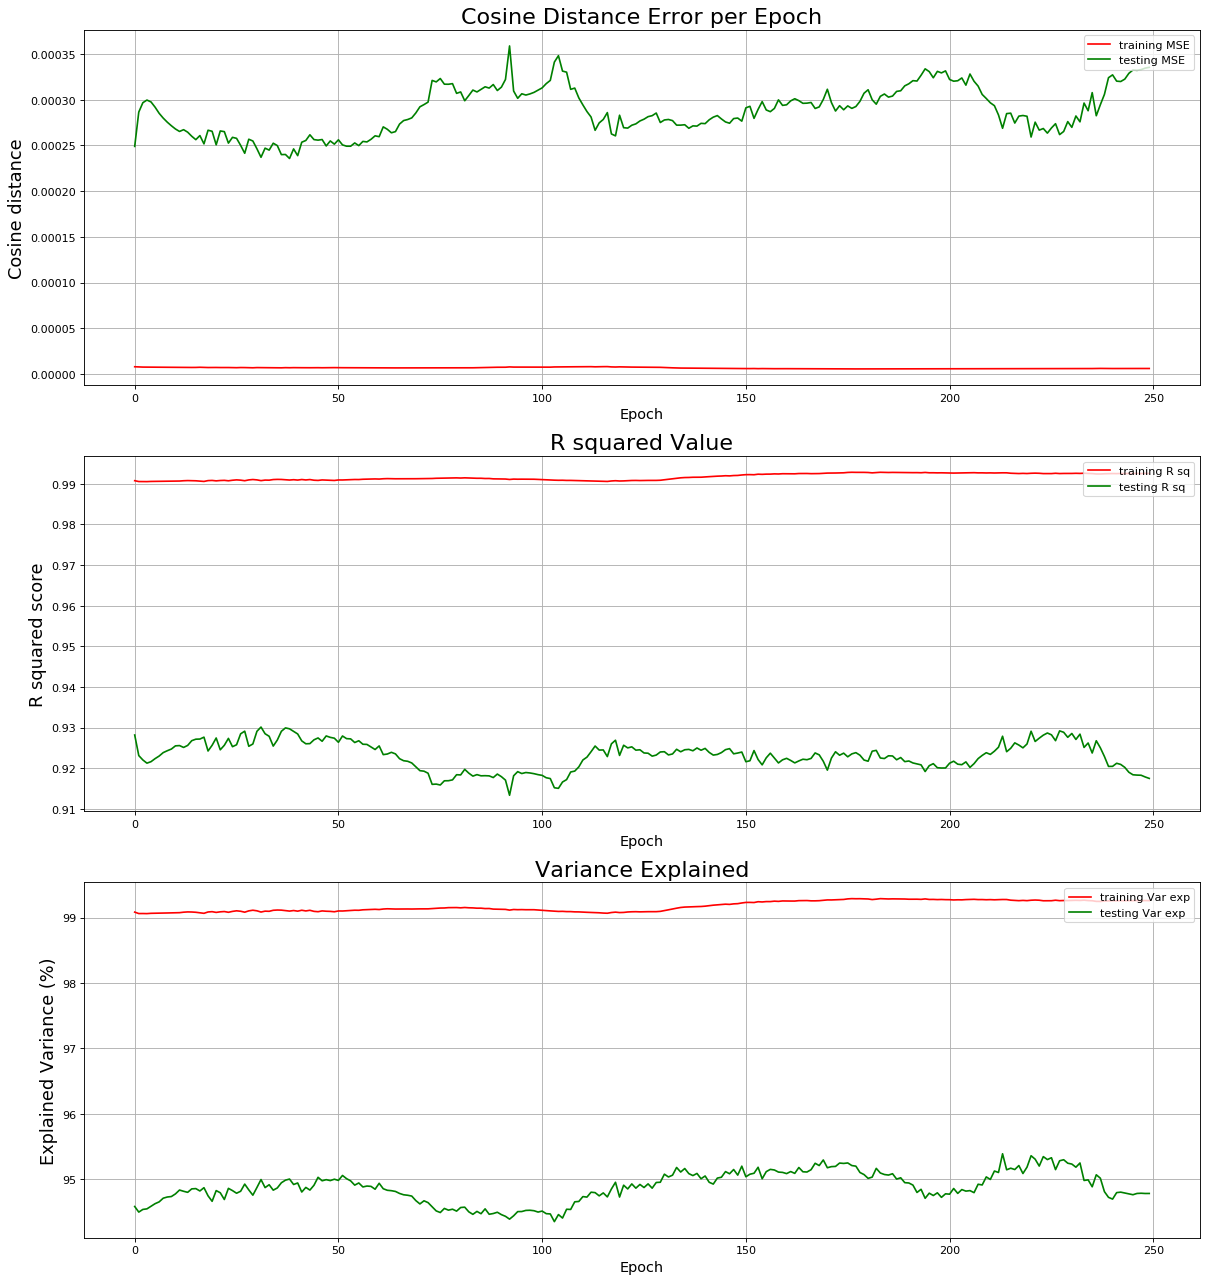

In [39]:
train_loss = np.squeeze(np.mean(np.array(loss_lst_train), axis=2))
test_loss = np.squeeze(np.mean(np.array(loss_lst_test), axis=2))

plt.close()
plt.figure(num=None, figsize=(18, 20), dpi=80)

plt.subplot(311)
plt.title('Cosine Distance Error per Epoch', fontsize=20)
plt.plot( train_loss , 'r')            # this is the mean squared error among yaw, pitch, roll angles
plt.plot( test_loss  , 'g')            # can have a max value of 360^2 = 126000
# plt.plot( np.array(loss_lst_train) , 'r')            # this is the mean squared error among yaw, pitch, roll angles
# plt.plot( np.array(loss_lst_test)  , 'g')
plt.ylabel("Cosine distance", fontsize=16)
plt.xlabel("Epoch", fontsize=13)
# plt.ylim(-0.025,0.225)
plt.legend(['training MSE', 'testing MSE'], loc='upper right')
plt.grid()

plt.subplot(312)
plt.title("R squared Value", fontsize=20)
plt.plot(r_sq_lst, 'r')
plt.plot(r_sq_lst_test, 'g')
plt.ylabel("R squared score", fontsize=16)
plt.xlabel("Epoch", fontsize=13)
plt.legend(['training R sq', 'testing R sq'], loc='upper right')
plt.grid()

plt.subplot(313)
plt.title("Variance Explained", fontsize=20)
plt.plot(np.array(var_exp_lst) * 100, 'r')
plt.plot(np.array(var_exp_lst_test) * 100, 'g')
plt.ylabel("Explained Variance (%)", fontsize=16)
# plt.ylim(-50,110)
plt.xlabel("Epoch", fontsize=13)
plt.legend(['training Var exp', 'testing Var exp'], loc='upper right')
plt.grid()

# plt.savefig("network_training_loss.png")
plt.show()

### Loading Network weights that have the best testing loss

In [41]:
# state_dict = model.load_from_checkpoint("/the_good_weights/net1_v5_network_state_checkpoint80.pth")
# state_dict = model.load_from_checkpoint("/the_good_weights/net1_v3_network_state_checkpoint95.pth")
# state_dict = model.load_from_checkpoint("/saved_model_weights/Net1_v3.1/network_state_checkpoint150.pth")  #good
# state_dict = model.load_from_checkpoint("/saved_model_weights/Net1_v3.1_lsm2mpu/network_state_checkpoint695.pth")

state_dict = model.load_from_checkpoint("/saved_model_weights/Net1_v3.1_lsm2mpu/network_state_checkpoint35.pth")
model.load_state_dict(state_dict)

Loading model from 
/Users/crohan009/Documents/Stuff/USR18/code base/Sensor_fusion/saved_model_weights/Net1_v3.1_lsm2mpu/network_state_checkpoint35.pth 
...onto the CPU. 



In [42]:
# data_test2 = Network1_Data_loader("Datasets/MPU_rawtoypr_11_cleaned.csv", sequential_test_mode=True)
data_test2 = Network1_Data_loader("Datasets/LSM_rawto_MPUypr_{}_cleaned.csv".format(trial_num), 
                                  sequential_test_mode=True, trans=True)

dsets_enqueuer_trial = torch.utils.data.DataLoader(data_test2, batch_size=1, 
                                                      num_workers=1, drop_last=False)

y_lst = []
o_lst = []
#data_ctr = 0

for idx, data in enumerate(dsets_enqueuer_trial, 1):
        x,y = data['x'], data['y']
        
        #print(x.shape)
        #print(y.shape)
        
        if torch.cuda.is_available():
            x, y = Variable(x.cuda(), requires_grad = False).float(), Variable(y.cuda(), requires_grad = False).float()
        else:
            x, y = Variable(x, requires_grad = False).float(), Variable(y, requires_grad = False).float()

        model.eval()
        output = model(x)
        
        #print(output.shape)
        
        y_lst.append(y)
        o_lst.append(output)
        #data_ctr += 1
        #if data_ctr >= 5000:
        #    break
        
# print("Model output \t= {} \ny \t\t= {}".format(np.squeeze(output.data.numpy()), 
#                                          np.squeeze(y.data.numpy())))
    

In [43]:
# model_output = np.squeeze(np.array(o_lst) )
model_output = np.squeeze(np.array(o_lst))
expected = np.squeeze(np.array(y_lst))

pitch_out, pitch_exp     = model_output[:,0], expected[:,0]
roll_out, roll_exp = model_output[:,1], expected[:,1]
yaw_out, yaw_exp   = model_output[:,2], expected[:,2]

### Visualizing the testing loss 

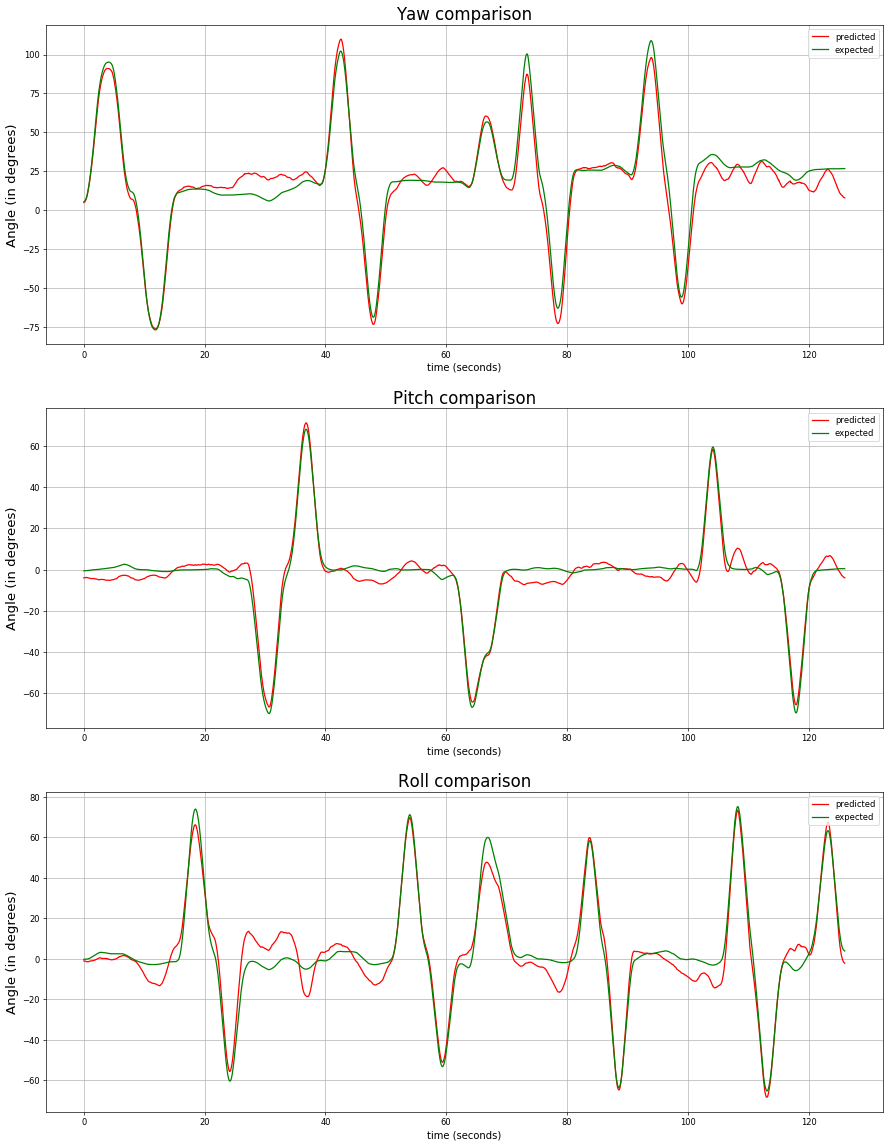

In [55]:
n = len(data_test2) - 99
t = data_test2.runtime
x = list(np.linspace(0, t, n))

plt.close()
plt.figure(num=None, figsize=(18, 24), dpi=60)

plt.subplot(311)
plt.title('Yaw comparison', fontsize=20)
# plt.plot( yaw_out , 'r')            # model output
plt.plot(x, np.convolve(yaw_out, np.ones((100,))/100, mode='valid'), 'r')      # moving average filtered
# plt.plot( yaw_exp  , 'g')            # expected output
plt.plot(x, np.convolve(yaw_exp, np.ones((100,))/100, mode='valid'), 'g')      # moving average filtered
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("time (seconds)", fontsize=12)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.subplot(312)
plt.title('Pitch comparison', fontsize=20)
# plt.plot( pitch_out , 'r')            # model output
plt.plot(x, np.convolve(pitch_out, np.ones((100,))/100, mode='valid'), 'r')      # moving average filtered
# plt.plot( pitch_exp  , 'g')            # expected output
plt.plot(x, np.convolve(pitch_exp, np.ones((100,))/100, mode='valid'), 'g')      # moving average filtered
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("time (seconds)", fontsize=12)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.subplot(313)
plt.title('Roll comparison', fontsize=20)
# plt.plot( roll_out , 'r')            # model output
plt.plot(x, np.convolve(roll_out, np.ones((100,))/100, mode='valid'), 'r')      # moving average filtered
# plt.plot( roll_exp  , 'g')            # expected output
plt.plot(x, np.convolve(roll_exp, np.ones((100,))/100, mode='valid'), 'g')      # moving average filtered
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("time (seconds)", fontsize=12)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.savefig("angle_comparison.png")
plt.show()

### Average Yaw, Pitch, Roll Difference (in degrees)

In [45]:
output_yaw = np.convolve(yaw_out, np.ones((100,))/100, mode='valid')
expected_yaw = np.convolve(yaw_exp, np.ones((100,))/100, mode='valid')
distance = 0

for i in range(len(output_yaw)):
    distance = distance + (expected_yaw[i] - output_yaw[i]).abs()

print("Average yaw Difference = ", (distance / len(output_yaw)).data.numpy(), "degrees")

# ----------------------------------------------------------------------------------------------------------------

output_pitch = np.convolve(pitch_out, np.ones((100,))/100, mode='valid')
expected_pitch = np.convolve(pitch_exp, np.ones((100,))/100, mode='valid')
distance = 0

for i in range(len(output_pitch)):
    distance = distance + (expected_pitch[i] - output_pitch[i]).abs()

print("Average pitch Difference = ", (distance / len(output_pitch)).data.numpy(), "degrees")

# ----------------------------------------------------------------------------------------------------------------

output_roll = np.convolve(roll_out, np.ones((100,))/100, mode='valid')
expected_roll = np.convolve(roll_exp, np.ones((100,))/100, mode='valid')
distance = 0

for i in range(len(output_roll)):
    distance = distance + (expected_roll[i] - output_roll[i]).abs()

print("Average roll Difference = ", (distance / len(output_roll)).data.numpy(), "degrees")

Average yaw Difference =  [5.686768] degrees
Average pitch Difference =  [3.4421268] degrees
Average roll Difference =  [5.329122] degrees


In [50]:
print("Average angle difference = ", round(sum([5.686768, 3.4421268, 5.329122])/3, 2), "degrees")

Average angle difference =  4.82 degrees
